# Introductory course to TimeSeries ForeCasting - AnalyticsVidhya

# Problem Statement
Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

# Table of Contents
**1. Understanding Data:**
    1. Hypothesis Generation
    2. Getting the system ready and loading the data
    3. Dataset Structure and Content
    4. Feature Extraction
    5. Exploratory Analysis
**2. Forecasting using Multiple Modeling Techniques:**
    1. Splitting the data into training and validation part
    2. Modeling techniques
    3. Holt’s Linear Trend Model on daily time series
    4. Holt Winter’s Model on daily time series
    5. Introduction to ARIMA model
    6. Parameter tuning for ARIMA model
    7. SARIMAX model on daily time series

# 1. Understanding the data

## 1.1 Hypothesis Generation
The hypothesis generation is the first step before looking at the data, we will list out all the possible factors that can affect the outcome. The purpose of this step is to avoid any bias that may result after the observation.   

Here are some of the hypotheses which I think can affect the passenger count (dependent variable for this time series problem) on the JetRail:  

**1. There will be an increase in the traffic as the years pass by.**
Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also, generally companies expand their businesses over time leading to more customers travelling through JetRail.  

**2. The traffic will be high from May to October.**
Tourist visits generally increases during this time perion.  

**3. Traffic on weekdays will be more as compared to weekends/holidays.**
People will go to office on weekdays and hence the traffic will be high.  

**4. Traffic during the peak hours will be high.**
People will travel to work, college.  

We will try to validate each of these hypothesis based on the dataset. Now let’s have a look at the dataset.

## 1.2 Imports & Loading data

In [1]:
import pandas as pd 

import numpy as np          # For mathematical calculations 

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use(['ggplot']) # For plotting graphs 

from datetime import datetime    # To access datetime 

from pandas import Series        # To work on series 

%matplotlib inline 

import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")

In [2]:
# file paths
train_file_path = 'data/train.csv'
test_file_path = 'data/test.csv'

# loading
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

# copies to keep the orignials
train_original=train.copy() 
test_original=test.copy()

print("Datasets loaded !")

Datasets loaded !


## 1.3 Dataset Structure and Content

**Heads**

In [3]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
test.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


**Types**

In [5]:
print("Train :\n",train.dtypes)
print("-"*25)
print("Test :\n",test.dtypes)

Train :
 ID           int64
Datetime    object
Count        int64
dtype: object
-------------------------
Test :
 ID           int64
Datetime    object
dtype: object


**Shapes**

In [6]:
print("Shape of train set : ", train.shape)
print("Shape of test set : ", test.shape)

Shape of train set :  (18288, 3)
Shape of test set :  (5112, 2)


**Summary**

* ID is the unique number given to each observation point - Integer.
* Datetime is the time of each observation - Object
* Count is the passenger count corresponding to each Datetime - Integer.  

* **18288** train examples and **5112** test examples.

# 1.4 Feature Extraction 

We need to extract time and date from de Datetime features, except that its type is "object" which is not appropriate. We therefore need to converit it into a Datetime type so that we can easily manipulate it and extract from it what we need.

In [7]:
for df in [train, test, train_original, test_original] :
    df['Datetime'] = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 

We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

In [8]:
for df in [train, test, train_original, test_original] :
    df['Year'] = df.Datetime.dt.year
    df['Month'] = df.Datetime.dt.month
    df['Day'] = df.Datetime.dt.day
    df['Hour'] = df.Datetime.dt.hour

We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic : 
* We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.
* Values of 5 and 6 represents that the days are weekend.

In [9]:
def weekender(row):
    if row.dayofweek == 5 or row.dayofweek == 6 :
        return 1
    else :
        return 0

for df in [train, test] :
    df['DayOfWeek'] = df.Datetime.dt.dayofweek
    df['Weekend'] = df.Datetime.apply(weekender)

Let's now drop the ID column and index with the Datetime :

In [10]:
for df in [train, test] :
    df.index = df.Datetime
    df.drop(columns=['ID'],inplace=True)

Let's take a look at our data set:

In [11]:
train.sample(5)

,Datetime,Count,Year,Month,Day,Hour,DayOfWeek,Weekend
Datetime,,,,,,,,
2014-06-09 12:00:00,2014-06-09 12:00:00,476,2014,6,9,12,0,0
2013-03-11 17:00:00,2013-03-11 17:00:00,22,2013,3,11,17,0,0
2014-02-03 17:00:00,2014-02-03 17:00:00,238,2014,2,3,17,0,0
2014-05-13 07:00:00,2014-05-13 07:00:00,128,2014,5,13,7,1,0
2012-10-14 05:00:00,2012-10-14 05:00:00,2,2012,10,14,5,6,1


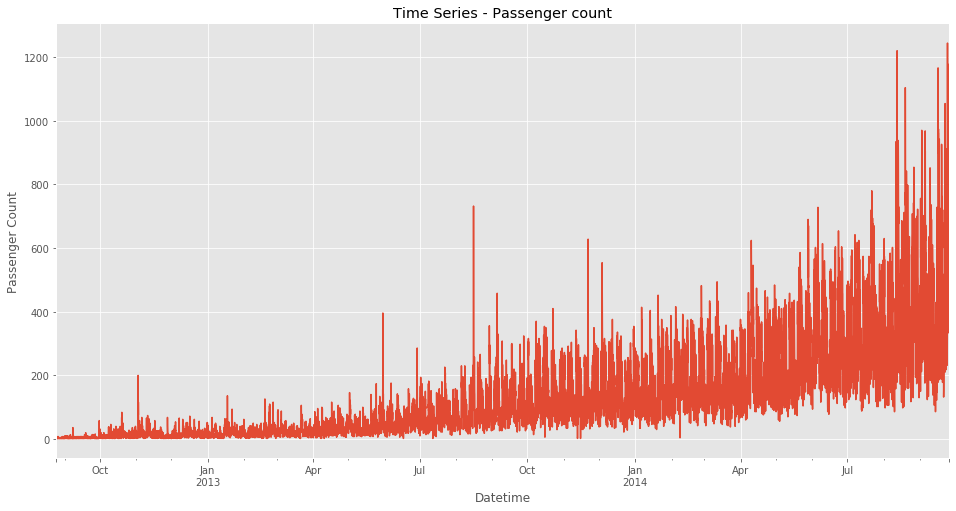

In [12]:
train['Count'].plot(kind='line', 
                    figsize=(16,8))
plt.title('Time Series - Passenger count')
plt.ylabel('Passenger Count')
plt.show()

Here we can infer that there is an increasing trend in the series, i.e., the number of count is increasing with respect to time. We can also see that at certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event the traffic was high.

We will work on the train file for all the analysis and will use the test file for forecasting.

## 1.5 Exploratory Analysis

Lets recall the hypothesis that we made earlier:

* Traffic will increase as the years pass by
* Traffic will be high from May to October
* High traffic on weekdays
* Traffic during the peak hours will be high

After having a look at the dataset, we will now try to validate our hypothesis and make other inferences from the dataset.

**Traffic will increase as the years pass by :**

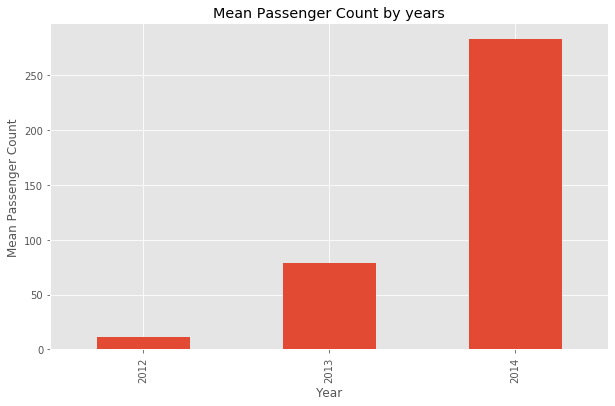

In [13]:
train.groupby('Year')['Count'].mean().plot(kind='bar',
                                 figsize=(10,6))

plt.title('Mean Passenger Count by years')
plt.ylabel('Mean Passenger Count')
plt.show()

**Traffic will be high from May to October**

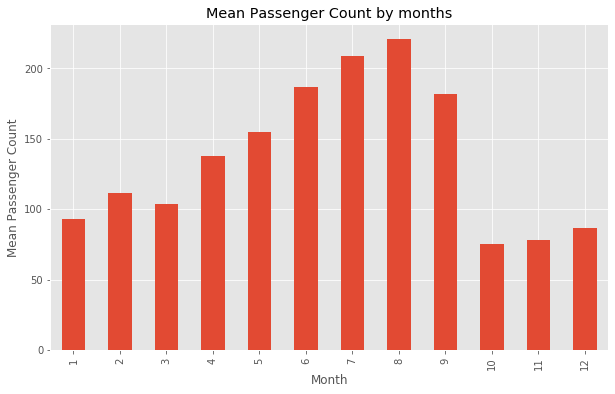

In [14]:
train.groupby('Month')['Count'].mean().plot(kind='bar',
                                 figsize=(10,6))

plt.title('Mean Passenger Count by months')
plt.ylabel('Mean Passenger Count')
plt.show()

Here we see a decrease in the mean of passenger count in last three months. This does not look right. Let’s look at the monthly mean of each year separately.

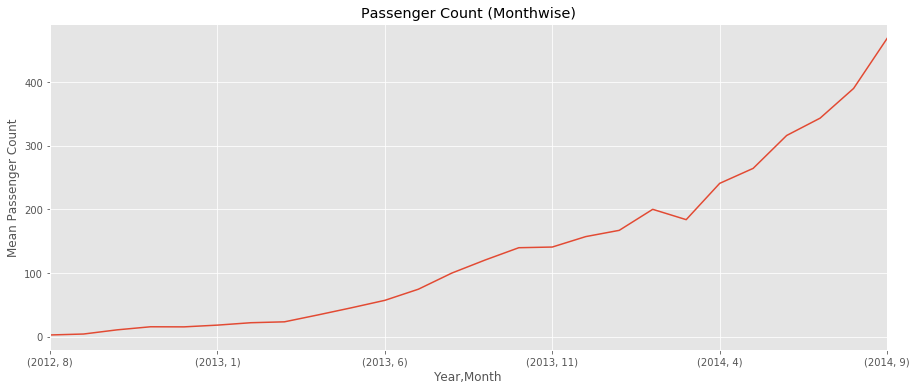

In [15]:
train.groupby(['Year', 'Month'])['Count'].mean().plot(kind='line',
                                                     figsize=(15,6))
plt.title('Passenger Count (Monthwise)')
plt.ylabel('Mean Passenger Count')
plt.show()

* We see that the months 10, 11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very low.
* Since there is an increasing trend in our time series, the mean value for rest of the months will be high because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months.
* In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.

**High traffic on weekdays**

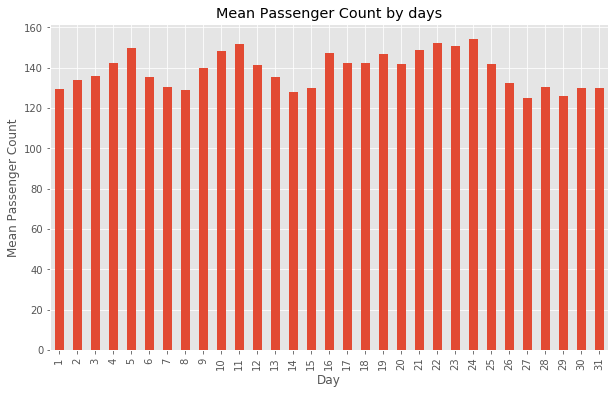

In [16]:
train.groupby('Day')['Count'].mean().plot(kind='bar',
                                 figsize=(10,6))

plt.title('Mean Passenger Count by days')
plt.ylabel('Mean Passenger Count')
plt.show()

We are not getting much insights from day wise count of the passengers, but we can assume that the holes around day 8 and 15 are weekends, let's see the mean passenger counts in weekend/workdays :

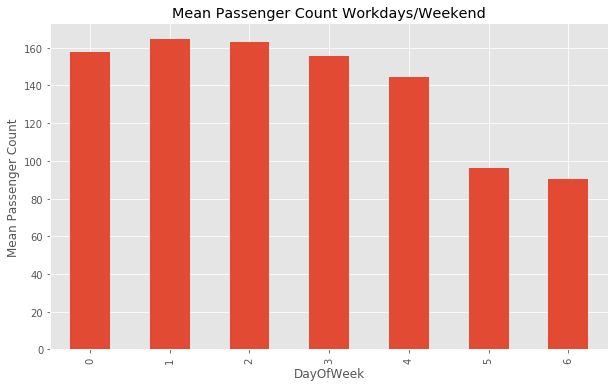

In [17]:
train.groupby('DayOfWeek')['Count'].mean().plot(kind='bar',
                                             figsize=(10,6))
plt.title('Mean Passenger Count Workdays/Weekend')
plt.ylabel('Mean Passenger Count')
plt.show()

**High traffic on peak hours**

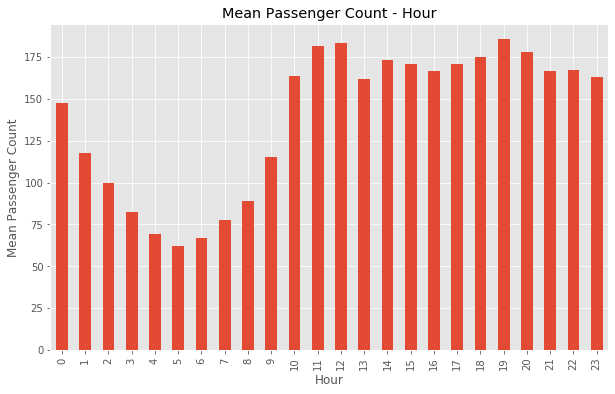

In [18]:
train.groupby('Hour')['Count'].mean().plot(kind='bar',
                                             figsize=(10,6))
plt.title('Mean Passenger Count - Hour')
plt.ylabel('Mean Passenger Count')
plt.show()

We can notice :
* Peak traffic strats at 7AM, decreasing trend after midnight till 5AM.
* Peaks at 12PM and 19PM

As we've seen, there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

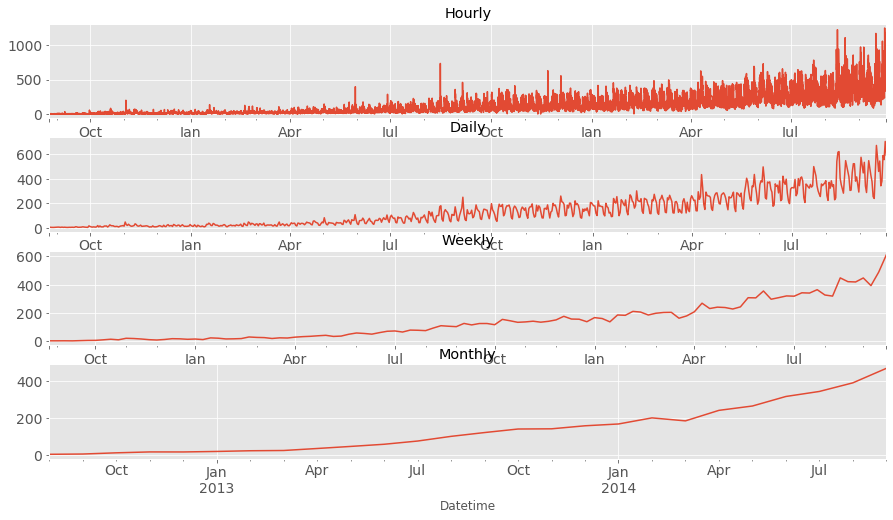

In [19]:
# Hourly time series 
hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.show()

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become a very expensive process. So, we will work on the daily time series.

In [20]:
train

,Datetime,Count,Year,Month,Day,Hour,DayOfWeek,Weekend
Datetime,,,,,,,,
2012-08-25 00:00:00,2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2012-08-25 04:00:00,2,2012,8,25,4,5,1
...,...,...,...,...,...,...,...,...
2014-09-25 19:00:00,2014-09-25 19:00:00,868,2014,9,25,19,3,0
2014-09-25 20:00:00,2014-09-25 20:00:00,732,2014,9,25,20,3,0
2014-09-25 21:00:00,2014-09-25 21:00:00,702,2014,9,25,21,3,0


In [21]:
train = train.resample('D').mean()
test = test.resample('D').mean()

for df in [train,test] :
#     df.drop(columns=['Year','Month','Day','Hour','DayOfWeek','Weekend'],inplace=True)
    None
train.head()

,Count,Year,Month,Day,Hour,DayOfWeek,Weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


# 2. Forecasting using Multiple Modeling Techniques:

## 1. Splitting the data into training and validation part

Now we will divide our data in train and validation. We will make a model on the train part and predict on the validation part to check the accuracy of our predictions.

To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.

The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.

In [22]:
train_set = train.loc['2012-08-25':'2014-06-24']
val_set = train.loc['2014-06-25':'2014-09-25']

Now let's look at how the train and validation part has been divided :

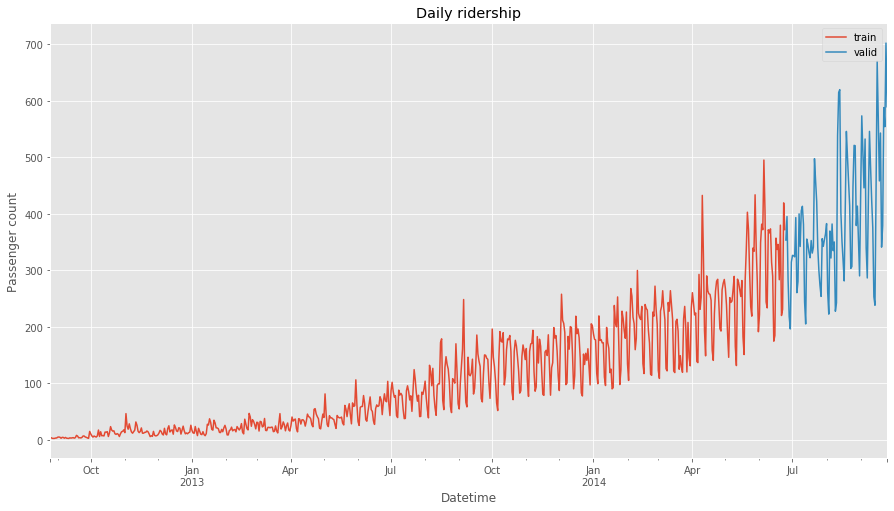

In [23]:
train_set.Count.plot(figsize=(15,8), label='train')
val_set.Count.plot(figsize=(15,8), label='valid')

plt.title("Daily ridership")
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

## 2. Modeling Techniques

We will look at various models now to forecast the time series :
   * Naive Approach
   * Moving Average
   * Simple Exponential Smoothing
   * Holt's Linear Trend Model

### Naive Approach
In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we expect the prediction to be a straight horizontal line.

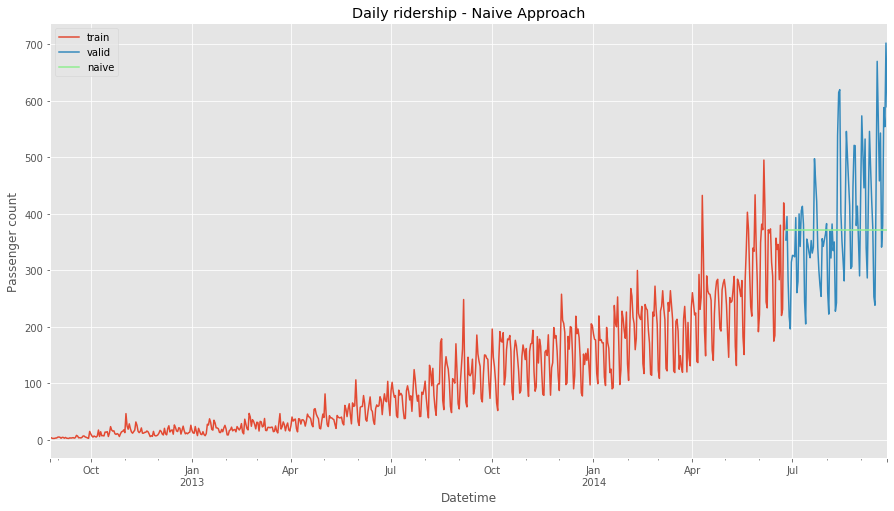

In [24]:
y_hat = val_set.copy()
y_hat['Naive'] = train_set.iloc[-1].Count

train_set.Count.plot(figsize=(15,8), label='train')
val_set.Count.plot(figsize=(15,8), label='valid')
y_hat.Naive.plot(figsize=(15,8), color='lightgreen', label='naive')

plt.title("Daily ridership - Naive Approach")
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

Let's see how accurate our predictions are using RMSE metric (Root Mean Square Error) :

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_naive = sqrt(mean_squared_error(val_set.Count, y_hat.Naive))

print("RMSE naive : ",rmse_naive)

RMSE naive :  111.79050467496724


### Moving Average
Here the predictions are made on the basis of the average of last few points instead of taking all the previously known values. We can try many values : 10 days, 20 days ...

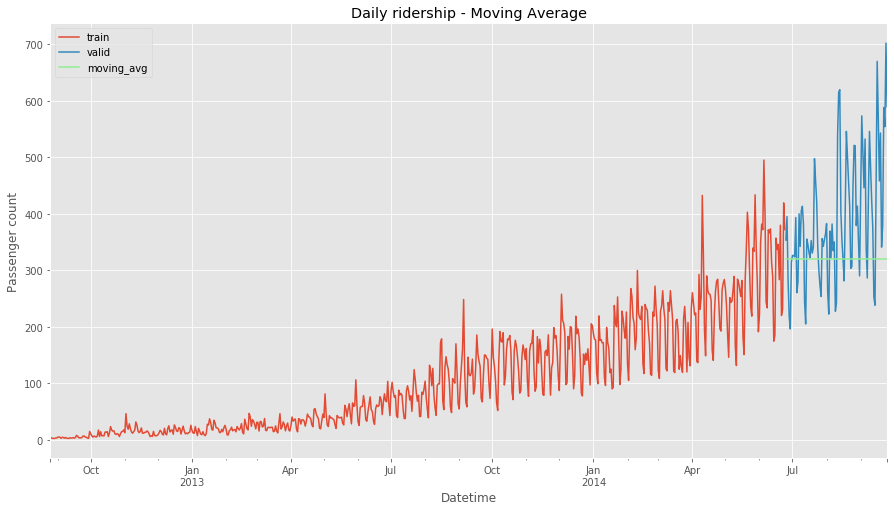

In [26]:
y_hat['MovingAvg'] = train_set['Count'].rolling(20).mean().iloc[-1]

train_set.Count.plot(figsize=(15,8), label='train')
val_set.Count.plot(figsize=(15,8), label='valid')
y_hat.MovingAvg.plot(figsize=(15,8), color='lightgreen', label='moving_avg')

plt.title("Daily ridership - Moving Average")
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

In [27]:
rmse_mavg = sqrt(mean_squared_error(val_set.Count, y_hat.MovingAvg))

print("RMSE Moving Average : ",rmse_mavg)

RMSE Moving Average :  130.44984977550422


### Simple Exponential Smoothing
In this technique, we assign larger weights to more recent observations than to observations from the distant past. The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

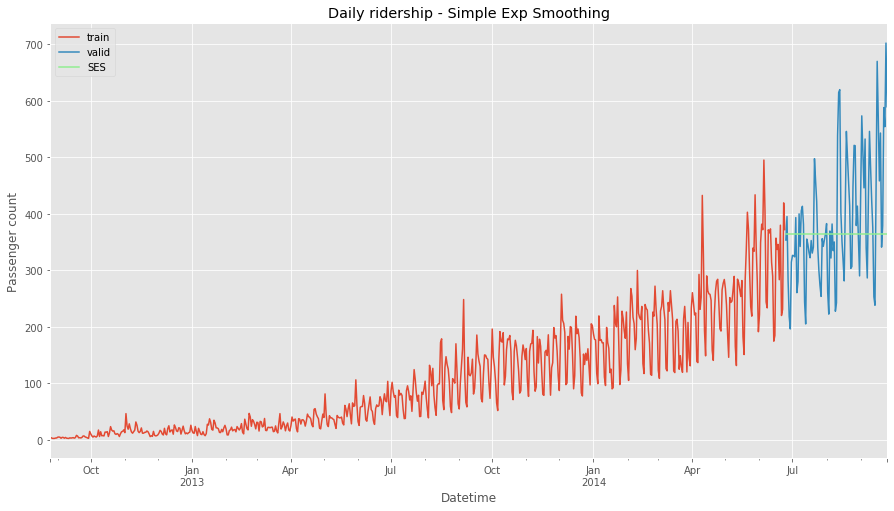

In [28]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 

ses = SimpleExpSmoothing(np.asarray(train_set.Count)).fit(smoothing_level=0.6,optimized=False)

y_hat['SES'] = ses.forecast(len(val_set))

train_set.Count.plot(figsize=(15,8), label='train')
val_set.Count.plot(figsize=(15,8), label='valid')
y_hat.SES.plot(figsize=(15,8), color='lightgreen', label='SES')

plt.title("Daily ridership - Simple Exp Smoothing")
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

In [29]:
rmse_ses = sqrt(mean_squared_error(val_set.Count, y_hat.SES))

print("RMSE Simple Exponential Smoothing : ",rmse_ses)

RMSE Simple Exponential Smoothing :  113.43708111884514


### Holt's Linear Trend Model
It is an extension of simple exponential smoothing to allow forecasting of data with a trend. This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.

We can decompose the time series in four parts.

* Observed, which is the original time series.
* Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
* Seasonal, which tells us about the seasonality in the time series.
* Residual, which is obtained by removing trend and seasonality in the time series.

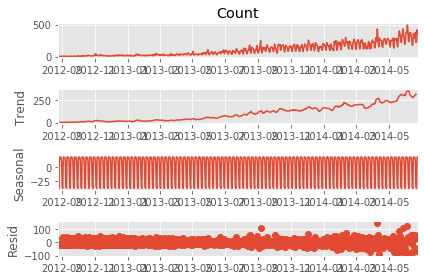

In [30]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train_set.Count).plot() 

result = sm.tsa.stattools.adfuller(train_set.Count)

plt.show()

An increasing trend can be seen in the dataset, so now we will make a model based on the trend.

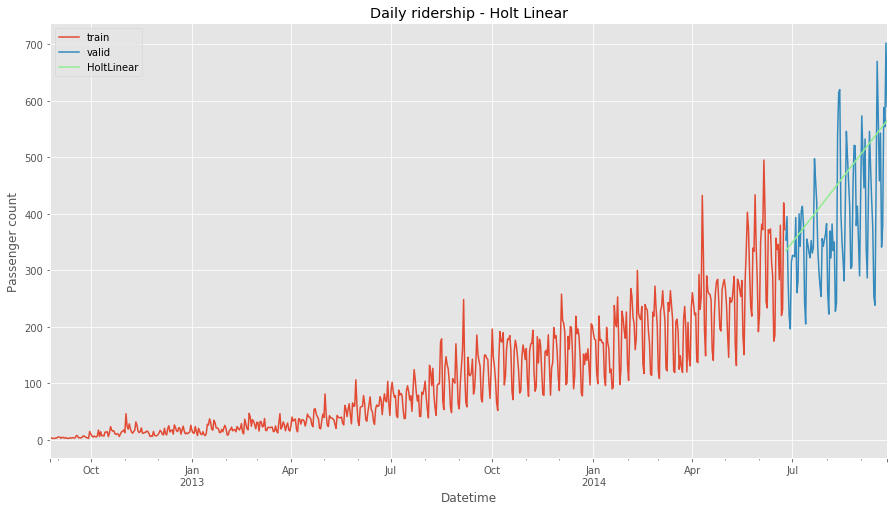

In [31]:
holt = Holt(np.asarray(train_set['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 

y_hat['Holt'] = holt.forecast(len(val_set)) 

train_set.Count.plot(figsize=(15,8), label='train')
val_set.Count.plot(figsize=(15,8), label='valid')
y_hat.Holt.plot(figsize=(15,8), color='lightgreen', label='HoltLinear')

plt.title("Daily ridership - Holt Linear")
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

In [32]:
rmse_holt = sqrt(mean_squared_error(val_set.Count, y_hat.Holt))

print("RMSE Simple Exponential Smoothing : ",rmse_holt)

RMSE Simple Exponential Smoothing :  112.94278345314041


## 3. Holt’s Linear Trend Model on daily time series

Now let’s try to make holt’s linear trend model on the daily time series and make predictions on the test dataset.
* We will make predictions based on the daily time series and then will distribute that daily prediction to hourly predictions.
* We have fitted the holt’s linear trend model on the train dataset and validated it using validation dataset.

In [33]:
submission = pd.read_csv("data/submission.csv")

In [34]:
submission.head()

,ID,Count
0,18288,0
1,18289,0
2,18290,0
3,18291,0
4,18292,0


In [35]:
predict=holt.forecast(len(test))

In [36]:
test['Prediction_Holt']=predict

Remember this is the daily predictions. We have to convert these predictions to hourly basis. To do so we will first :
* Calculate the ratio of passenger count for each hour of every day. 
* Then we will find the average ratio of passenger count for every hour and we will get 24 ratios. 
* Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio.

In [37]:
train_original['Ratio'] = train_original['Count']/train_original['Count'].sum()

Ratio=train_original.groupby(['Hour'])['Ratio'].sum() 
Ratio

Hour
0     0.044287
1     0.035343
2     0.029911
3     0.024714
4     0.020802
5     0.018621
6     0.020023
7     0.023221
8     0.026741
9     0.034555
10    0.049047
11    0.054375
12    0.054951
13    0.048600
14    0.051965
15    0.051309
16    0.049999
17    0.051164
18    0.052423
19    0.055627
20    0.053455
21    0.049895
22    0.050076
23    0.048892
Name: Ratio, dtype: float64

In [38]:
test_original = pd.merge(test_original, Ratio, on=('Hour'), how='left')
test_original

,ID,Datetime,Year,Month,Day,Hour,Ratio
0,18288,2014-09-26 00:00:00,2014,9,26,0,0.044287
1,18289,2014-09-26 01:00:00,2014,9,26,1,0.035343
2,18290,2014-09-26 02:00:00,2014,9,26,2,0.029911
3,18291,2014-09-26 03:00:00,2014,9,26,3,0.024714
4,18292,2014-09-26 04:00:00,2014,9,26,4,0.020802
...,...,...,...,...,...,...,...
5107,23395,2015-04-26 19:00:00,2015,4,26,19,0.055627
5108,23396,2015-04-26 20:00:00,2015,4,26,20,0.053455
5109,23397,2015-04-26 21:00:00,2015,4,26,21,0.049895
5110,23398,2015-04-26 22:00:00,2015,4,26,22,0.050076


In [39]:
submission = pd.merge(test_original,test, on=('Month','Day'), how='left')
submission['Count'] = submission['Ratio'] * submission['Prediction_Holt'] * 24

submission = submission[['ID','Count']]


submission.to_csv('submissionholt1.csv',index=False)


submission

,ID,Count
0,18288,355.692974
1,18289,283.861602
2,18290,240.234347
3,18291,198.497058
4,18292,167.075574
...,...,...
5107,23395,1156.675482
5108,23396,1111.525192
5109,23397,1037.491153
5110,23398,1041.255041


## 4. Holt winter’s model on daily time 
**Seasonality :** similar set of pattern after fixed intervals of a time.

The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

Let’s first fit the model on training dataset and validate it using the validation dataset :

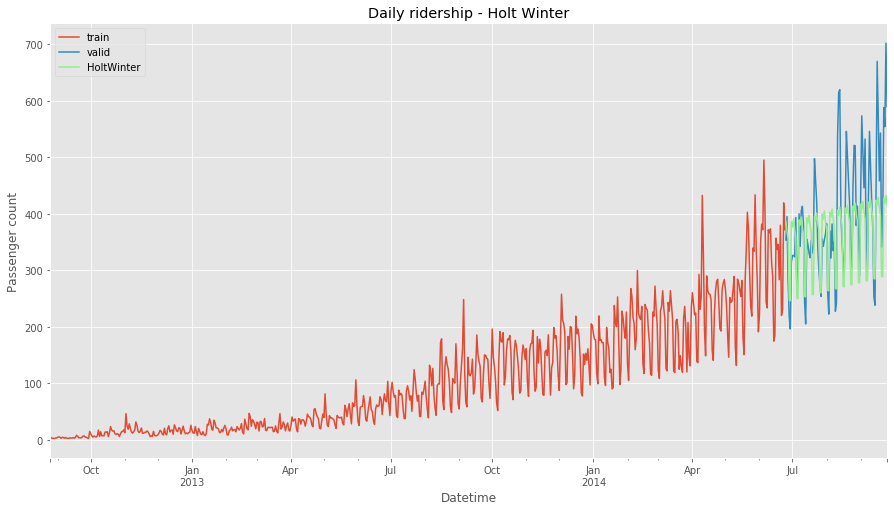

In [40]:
holt_winter = ExponentialSmoothing(np.asarray(train_set['Count']),
                            seasonal_periods=7,
                            trend='add',
                            seasonal='add').fit() 

y_hat['HoltWinter'] = holt_winter.forecast(len(val_set))

train_set.Count.plot(figsize=(15,8), label='train')
val_set.Count.plot(figsize=(15,8), label='valid')
y_hat.HoltWinter.plot(figsize=(15,8), color='lightgreen', label='HoltWinter')

plt.title("Daily ridership - Holt Winter")
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

In [41]:
rmse_holt_winter = sqrt(mean_squared_error(val_set.Count, y_hat.HoltWinter))

print("RMSE Holt Winter : ", rmse_holt_winter)

RMSE Holt Winter :  82.3793913863196


Let's now predict on the test set :

In [42]:
test['Prediction_Holt_Winter']=holt_winter.forecast(len(test))
test

,Year,Month,Day,Hour,DayOfWeek,Weekend,Prediction_Holt,Prediction_Holt_Winter
Datetime,,,,,,,,
2014-09-26,2014.0,9.0,26.0,11.5,4.0,0.0,334.650767,387.357688
2014-09-27,2014.0,9.0,27.0,11.5,5.0,1.0,337.159011,369.133911
2014-09-28,2014.0,9.0,28.0,11.5,6.0,1.0,339.667256,355.561136
2014-09-29,2014.0,9.0,29.0,11.5,0.0,0.0,342.175500,247.087192
2014-09-30,2014.0,9.0,30.0,11.5,1.0,0.0,344.683745,246.190329
...,...,...,...,...,...,...,...,...
2015-04-22,2015.0,4.0,22.0,11.5,2.0,0.0,856.365605,487.182793
2015-04-23,2015.0,4.0,23.0,11.5,3.0,0.0,858.873849,478.105419
2015-04-24,2015.0,4.0,24.0,11.5,4.0,0.0,861.382094,492.157680


In [43]:
submission = pd.merge(test_original,test, on=('Month','Day'), how='left')
submission['Count'] = submission['Ratio'] * submission['Prediction_Holt_Winter'] * 24

submission = submission[['ID','Count']]


submission.to_csv('submissionholtwinter.csv',index=False)


submission

,ID,Count
0,18288,411.714007
1,18289,328.569317
2,18290,278.070844
3,18291,229.760004
4,18292,193.389690
...,...,...
5107,23395,614.599840
5108,23396,590.609220
5109,23397,551.271213
5110,23398,553.271156


Holt winters model produced rmse of 333 on the leaderboard.  

The possible reason behind this may be that this model was not that good in predicting the trend of the time series but worked really well on the seasonality part.
Till now we have made different models for trend and seasonality. Can’t we make a model which will consider both the trend and seasonality of the time series?

Yes we can. We will look at the ARIMA model for time series forecasting.

## 5. Introduction to ARIMA model
ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).

* **p** is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
* **d** is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* **q** is the order of moving average model. 

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

**What is a stationary time series?**

There are three basic criterion for a series to be classified as stationary series :

* The mean of the time series should not be a function of time. It should be constant.
* The variance of the time series should not be a function of time.
* The covariance of the ith term and the (i+m)th term should not be a function of time.

We make the series stationary to make the variables independent. Variables can be dependent in various ways, but can only be independent in one way. So, we will get more information when they are independent. Hence the time series must be stationary.

If the time series is not stationary, firstly we have to make it stationary. For doing so, we need to remove the trend and seasonality from the data.

## 6. Parameter tuning for ARIMA model
First of all we have to make sure that the time series is stationary. If the series is not stationary, we will make it stationary.

**Stationarity Check :**  
We use Dickey Fuller test to check the stationarity of the series.
* The intuition behind this test is that it determines how strongly a time series is defined by a trend.
* The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
* The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

To run this test, we wil consider two values : Test Statistics and Critical value. If the Test Statistics is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept the null hypothesis (non-stationary).

Let’s make a function which we can use to calculate the results of Dickey-Fuller test :

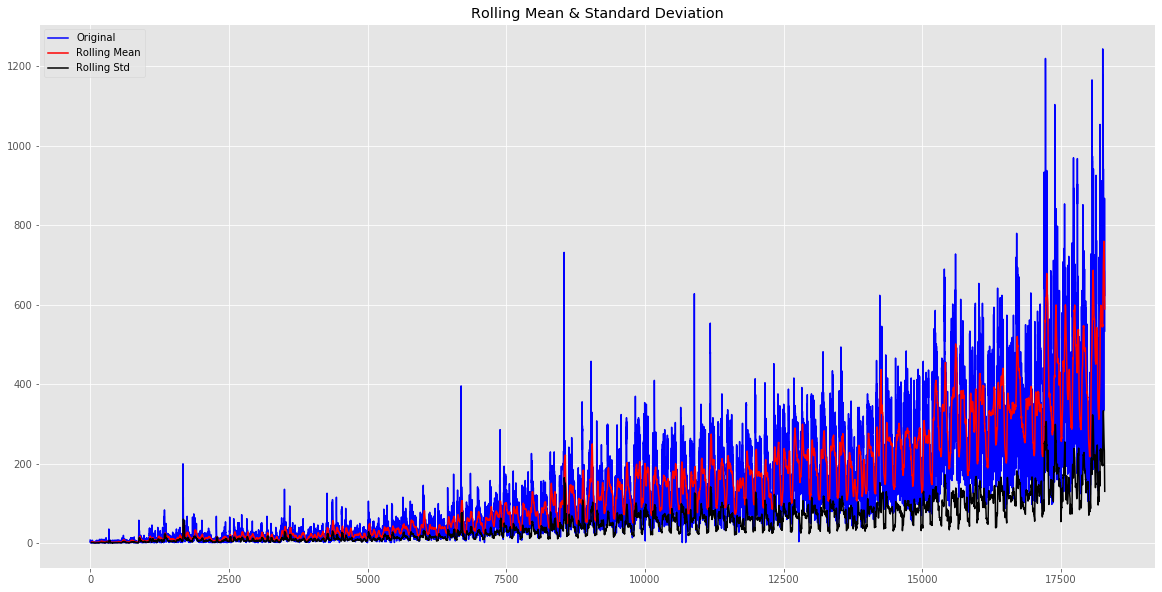

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [44]:
from statsmodels.tsa.stattools import adfuller 

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10

test_stationarity(train_original['Count'])

The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

## 7. SARIMA :

we can clearly see we have a time series with a seasonal component, so it make sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

One simple approach is to perform a grid search over multiple values of p,d,q,P,D,and Q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.

The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.

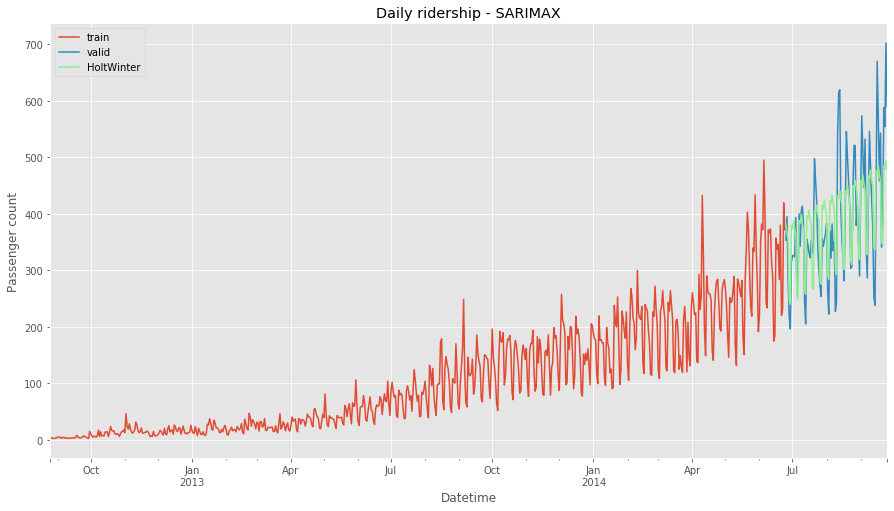

In [70]:
sarimax = sm.tsa.statespace.SARIMAX(train_set.Count, order=(2,1,1),seasonal_order=(0,1,1,7)).fit(maxiter=200) 


y_hat['Sarimax'] = sarimax.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 

train_set.Count.plot(figsize=(15,8), label='train')
val_set.Count.plot(figsize=(15,8), label='valid')
y_hat.Sarimax.plot(figsize=(15,8), color='lightgreen', label='HoltWinter')

plt.title("Daily ridership - SARIMAX")
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

In [71]:
rmse_sarimax = sqrt(mean_squared_error(val_set.Count, y_hat.Sarimax))

print("RMSE Sarima : ", rmse_sarimax)

RMSE Sarima :  68.28810068933782


Let's now predict on the test set :

In [67]:
test['Prediction_Sarimax']=sarimax.predict(start="2014-9-26", end="2015-4-26") 
test

,Year,Month,Day,Hour,DayOfWeek,Weekend,Prediction_Holt,Prediction_Holt_Winter,Prediction_Sarimax
Datetime,,,,,,,,,
2014-09-26,2014.0,9.0,26.0,11.5,4.0,0.0,334.650767,387.357688,466.989406
2014-09-27,2014.0,9.0,27.0,11.5,5.0,1.0,337.159011,369.133911,359.782211
2014-09-28,2014.0,9.0,28.0,11.5,6.0,1.0,339.667256,355.561136,354.369701
2014-09-29,2014.0,9.0,29.0,11.5,0.0,0.0,342.175500,247.087192,493.571199
2014-09-30,2014.0,9.0,30.0,11.5,1.0,0.0,344.683745,246.190329,488.196326
...,...,...,...,...,...,...,...,...,...
2015-04-22,2015.0,4.0,22.0,11.5,2.0,0.0,856.365605,487.182793,758.152822
2015-04-23,2015.0,4.0,23.0,11.5,3.0,0.0,858.873849,478.105419,742.615111
2015-04-24,2015.0,4.0,24.0,11.5,4.0,0.0,861.382094,492.157680,730.537544


In [68]:
submission = pd.merge(test_original,test, on=('Month','Day'), how='left')
submission['Count'] = submission['Ratio'] * submission['Prediction_Sarimax'] * 24

submission = submission[['ID','Count']]


submission.to_csv('submissionsarimax.csv',index=False)


submission

,ID,Count
0,18288,496.352817
1,18289,396.115516
2,18290,335.235733
3,18291,276.993309
4,18292,233.146106
...,...,...
5107,23395,824.944117
5108,23396,792.742807
5109,23397,739.941528
5110,23398,742.625943
